# Predicting 30-day Readmission from Demographic and Medication Patterns

This unified notebook reproduces the full pipeline for the final project:

1. **Build cohort & features** from the Kaggle dataset.
2. **Train baseline logistic regression models** on tabular features.
3. **Train a feedforward neural network** on the same features.
4. **Train logistic regression on neural network embeddings** and compare performance.

The code below is consolidated from the original notebooks `01_build_cohort.ipynb`, `02_model_baselines.ipynb`, `03_model_nn.ipynb`, and `04_lr_on_embeddings.ipynb`.

# 1. Build UCI cohort and features
This section loads the raw UCI diabetes cohort, cleans it, engineers features, and saves the processed cohort to `data_processed/admissions_features.csv`.

In [1]:
# 01_build_cohort.ipynb
# Build processed tabular cohort from diabetic_data.csv

import os
import numpy as np
import pandas as pd

RAW_PATH = "data_raw/diabetic_data.csv"
OUT_PATH = "data_processed/admissions_features.csv"

print("Loading raw data from:", RAW_PATH)
df_raw = pd.read_csv(RAW_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()

Loading raw data from: data_raw/diabetic_data.csv
Raw shape: (25000, 17)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [2]:
# Basic cleaning and label creation

df = df_raw.copy()

# Sometimes discharge_disposition_id codes for death/hospice are removed.
# If you want to keep it simple, we keep all for now. If you want to match
# common practice, uncomment the next block:

# codes_death_hospice = [11, 13, 14, 19, 20, 21]
# df = df[~df["discharge_disposition_id"].isin(codes_death_hospice)]

# 2. Create binary label: any readmission
df["label"] = (df["readmitted"].astype(str).str.lower() == "yes").astype(int)

print("Label positive rate:", df["label"].mean())
print("Cleaned shape:", df.shape)
df[["readmitted", "label"]].head()

Label positive rate: 0.47016
Cleaned shape: (25000, 18)


,readmitted,label
0,no,0
1,no,0
2,yes,1
3,yes,1
4,no,0


In [3]:
# Helper functions for feature engineering

def map_age_bucket(age_str: str) -> int:
    """
    Map age ranges like '[40-50)' to an integer bucket 0..9.
    If unknown, return -1.
    """
    if isinstance(age_str, str) and age_str.startswith("[") and age_str.endswith(")"):
        # age ranges in this dataset are like [0-10), [10-20), ..., [90-100)
        try:
            low = int(age_str[1:].split("-")[0])
            # each bin is 10 years wide
            return low // 10
        except Exception:
            return -1
    return -1


def map_diag_to_group(code) -> str:
    """
    Map ICD-9 diagnosis code (as string) to a coarse group.
    This is a simplified version of groupings used in prior work.
    """
    if pd.isna(code) or code == "?":
        return "missing"

    # codes in this dataset can be '250.83', '401', 'V57', 'E879', etc.
    s = str(code)
    # handle V and E codes as separate groups
    if s.startswith("V"):
        return "supplemental"
    if s.startswith("E"):
        return "injury_external"

    try:
        val = float(s)
    except ValueError:
        return "other"

    # diabetes
    if 250 <= val < 251:
        return "diabetes"
    # circulatory
    if (390 <= val <= 459) or (val == 785):
        return "circulatory"
    # respiratory
    if (460 <= val <= 519) or (val == 786):
        return "respiratory"
    # digestive
    if (520 <= val <= 579) or (val == 787):
        return "digestive"
    # injury/poisoning
    if 800 <= val <= 999:
        return "injury"
    # musculoskeletal
    if 710 <= val <= 739:
        return "musculoskeletal"
    # genitourinary
    if 580 <= val <= 629:
        return "genitourinary"
    # neoplasms
    if 140 <= val <= 239:
        return "neoplasm"

    return "other"


def encode_a1c(result: str) -> int:
    """
    Ordinal encoding for A1Cresult.
    Values in dataset: 'None', 'Norm', '>7', '>8' (sometimes slightly different).
    We'll map to 0..3
    """
    if result == "None":
        return 0
    if result == "Norm":
        return 1
    if result == ">7":
        return 2
    if result == ">8":
        return 3
    return 0  # default for '?', etc.

In [4]:
# Medication feature engineering

def build_medication_features(df):
    """
    Build features from diabetic_data.csv medication fields:
    - diabetes_med (Yes/No)
    - change (Up, Down, Steady, Ch, No)
    """
    df_feat = df.copy()

    # Binary: is the patient on diabetes medication?
    df_feat["on_diabetes_med"] = (df["diabetes_med"] == "Yes").astype(int)

    # Handle change column categories
    change_col = df["change"].fillna("No")

    df_feat["med_up"] = (change_col == "Up").astype(int)
    df_feat["med_down"] = (change_col == "Down").astype(int)
    df_feat["med_steady"] = (change_col == "Steady").astype(int)
    df_feat["med_changed"] = (change_col == "Ch").astype(int)
    df_feat["med_no_change"] = (change_col == "No").astype(int)

    return df_feat

In [5]:
# Apply medication features

df_feat = build_medication_features(df)

print("Shape after medication features:", df_feat.shape)
df_feat.head()

Shape after medication features: (25000, 24)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,...,change,diabetes_med,readmitted,label,on_diabetes_med,med_up,med_down,med_steady,med_changed,med_no_change
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,...,no,yes,no,0,0,0,0,0,0,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,...,no,yes,no,0,0,0,0,0,0,0
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,...,yes,yes,yes,1,0,0,0,0,0,0
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,...,yes,yes,yes,1,0,0,0,0,0,0
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,...,no,yes,no,0,0,0,0,0,0,0


In [6]:
# Choose columns for the modeling table

label_col = "label"

num_cols = [
    "time_in_hospital",
    "n_lab_procedures",
    "n_procedures",
    "n_medications",
    "n_outpatient",
    "n_inpatient",
    "n_emergency",
    "on_diabetes_med",
    "med_up",
    "med_down",
    "med_steady",
    "med_changed",
    "med_no_change",
]

cat_cols = [
    "age",
    "medical_specialty",
    "diag_1",
    "diag_2",
    "diag_3",
    "glucose_test",
    "A1Ctest",
]

# Filter to columns that actually exist (in case some are missing)
num_cols = [c for c in num_cols if c in df_feat.columns]
cat_cols = [c for c in cat_cols if c in df_feat.columns]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency', 'on_diabetes_med', 'med_up', 'med_down', 'med_steady', 'med_changed', 'med_no_change']
Categorical columns: ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']


In [7]:
# One-hot encode categoricals and assemble final feature table

df_num = df_feat[num_cols + [label_col]].copy()

# Convert categoricals to string and one-hot encode
df_cat = pd.get_dummies(
    df_feat[cat_cols].astype("category"),
    drop_first=False,
    dummy_na=True,
)

df_processed = pd.concat([df_num, df_cat], axis=1)

print("Processed shape:", df_processed.shape)
df_processed.head()

Processed shape: (25000, 64)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,on_diabetes_med,med_up,med_down,...,diag_3_Respiratory,diag_3_nan,glucose_test_high,glucose_test_no,glucose_test_normal,glucose_test_nan,A1Ctest_high,A1Ctest_no,A1Ctest_normal,A1Ctest_nan
0,8,72,1,18,2,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,3,34,2,13,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2,5,45,0,18,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
3,2,36,0,12,1,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,42,0,7,0,0,0,0,0,0,...,True,False,False,True,False,False,False,True,False,False


In [8]:
# Save processed cohort

out_path = "../data_processed/admissions_features.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_processed.to_csv(out_path, index=False)

print("Saved processed cohort to:", out_path)

Saved processed cohort to: ../data_processed/admissions_features.csv


# 2. Baseline model: Logistic regression
This section trains L2 and L1-regularized logistic regression models on the processed tabular features and evaluates them on validation and test splits.

In [9]:
# 02_model_baselines.ipynb
# Train baseline models on the processed UCI diabetes cohort

import sys
import os
import numpy as np
import pandas as pd

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from src.train import split_data
from src.models_baseline import train_logreg, train_logreg_l1
import matplotlib.pyplot as plt

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Shape:", df.shape)
df.head()

Shape: (25000, 64)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,on_diabetes_med,med_up,med_down,...,diag_3_Respiratory,diag_3_nan,glucose_test_high,glucose_test_no,glucose_test_normal,glucose_test_nan,A1Ctest_high,A1Ctest_no,A1Ctest_normal,A1Ctest_nan
0,8,72,1,18,2,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,3,34,2,13,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2,5,45,0,18,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
3,2,36,0,12,1,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,42,0,7,0,0,0,0,0,0,...,True,False,False,True,False,False,False,True,False,False


In [10]:
label_col = "label"

cols_to_drop = [label_col, "encounter_id", "patient_nbr"]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(columns=cols_to_drop)
y = df[label_col]

print("Shape:", X.shape)
print("Positive rate:", y.mean())

Shape: (25000, 63)
Positive rate: 0.47016


In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# Make sure we dropped ID columns from all splits
drop_cols = ["encounter_id", "patient_nbr", label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

X_train.shape, X_val.shape, X_test.shape

((17500, 63), (3750, 63), (3750, 63))

In [12]:
def eval_model(model, X, y, set_name="val"):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
    else:
        # fallback: use decision_function then squish
        scores = model.decision_function(X)
        # simple min-max scale as pseudo-prob
        probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

    preds = (probs >= 0.5).astype(int)

    metrics = {
        "set": set_name,
        "AUROC": roc_auc_score(y, probs),
        "AUPRC": average_precision_score(y, probs),
        "Accuracy": accuracy_score(y, preds),
    }
    return metrics, preds, probs

In [13]:
logreg = train_logreg(X_train, y_train)
logreg_l1 = train_logreg_l1(X_train, y_train)
logreg_metrics_val, logreg_preds_val, logreg_probs_val = eval_model(
    logreg, X_val, y_val, "val"
)
logreg_metrics_test, logreg_preds_test, logreg_probs_test = eval_model(
    logreg, X_test, y_test, "test"
)

logreg_l1_metrics_val, logreg_l1_preds_val, logreg_l1_probs_val = eval_model(
    logreg_l1, X_val, y_val, "val"
)
logreg_l1_metrics_test, logreg_l1_preds_test, logreg_l1_probs_test = eval_model(
    logreg_l1, X_test, y_test, "test"
)

logreg_metrics_val, logreg_metrics_test

({'set': 'val',
  'AUROC': 0.6545697915634837,
  'AUPRC': 0.6310828983944807,
  'Accuracy': 0.6208},
 {'set': 'test',
  'AUROC': 0.6307219273548057,
  'AUPRC': 0.6149408688407318,
  'Accuracy': 0.5994666666666667})

In [14]:
results_val = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_val},
    {"model": "LogReg_L1", **logreg_l1_metrics_val},
]).set_index("model")

results_test = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_test},
    {"model": "LogReg_L1", **logreg_l1_metrics_test},
]).set_index("model")

print("Validation:")
display(results_val)

print("\nTest:")
display(results_test)

Validation:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,val,0.654570,0.631083,0.620800
LogReg_L1,val,0.654595,0.631063,0.621867



Test:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,test,0.630722,0.614941,0.599467
LogReg_L1,test,0.630838,0.615062,0.599200


Confusion matrix (test, L2 Logistic Regression):
[[1381  606]
 [ 896  867]]


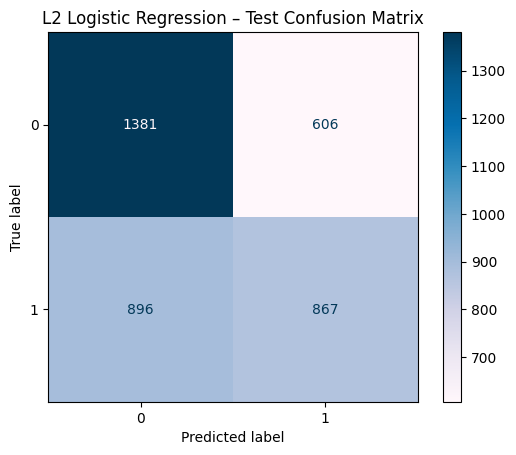

Classification report (test, L2 Logistic Regression):
              precision    recall  f1-score   support

           0      0.606     0.695     0.648      1987
           1      0.589     0.492     0.536      1763

    accuracy                          0.599      3750
   macro avg      0.598     0.593     0.592      3750
weighted avg      0.598     0.599     0.595      3750



In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_preds = logreg_preds_test
test_labels = y_test

cm = confusion_matrix(test_labels, test_preds)
print("Confusion matrix (test, L2 Logistic Regression):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("L2 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L2 Logistic Regression):")
print(classification_report(test_labels, test_preds, digits=3))

Confusion matrix (test, L1 Logistic Regression):
[[1381  606]
 [ 897  866]]


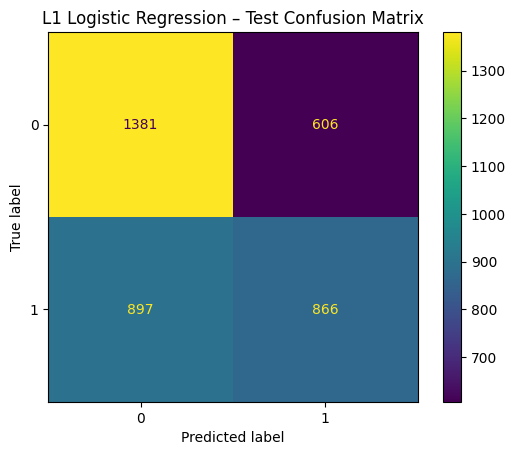

Classification report (test, L1 Logistic Regression):
              precision    recall  f1-score   support

           0      0.606     0.695     0.648      1987
           1      0.588     0.491     0.535      1763

    accuracy                          0.599      3750
   macro avg      0.597     0.593     0.591      3750
weighted avg      0.598     0.599     0.595      3750



In [16]:
cm_l1 = confusion_matrix(y_test, logreg_l1_preds_test)
print("Confusion matrix (test, L1 Logistic Regression):")
print(cm_l1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_l1, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("L1 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L1 Logistic Regression):")
print(classification_report(y_test, logreg_l1_preds_test, digits=3))

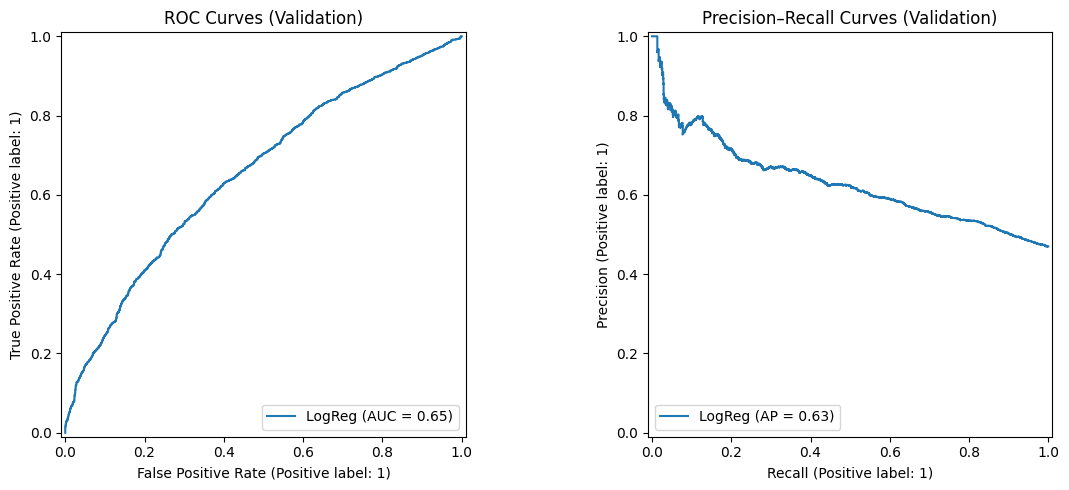

In [17]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[0], name="LogReg")
axes[0].set_title("ROC Curves (Validation)")

PrecisionRecallDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[1], name="LogReg")
axes[1].set_title("Precision–Recall Curves (Validation)")

plt.tight_layout()
plt.show()

# 3. Neural network on tabular features
This section builds and trains a small feedforward neural network on the same tabular features and compares performance to the baselines.

In [18]:
# 03_model_nn.ipynb
# Simple neural network model on the processed UCI diabetes cohort

import sys
import os

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

print("Repo root:", repo_root)

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

from src.train import split_data

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Raw processed shape:", df.shape)
df.head()

Repo root: /Users/vathsan/idle-workspace/COMPSCI184A
Raw processed shape: (25000, 64)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,on_diabetes_med,med_up,med_down,...,diag_3_Respiratory,diag_3_nan,glucose_test_high,glucose_test_no,glucose_test_normal,glucose_test_nan,A1Ctest_high,A1Ctest_no,A1Ctest_normal,A1Ctest_nan
0,8,72,1,18,2,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,3,34,2,13,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
2,5,45,0,18,0,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
3,2,36,0,12,1,0,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,42,0,7,0,0,0,0,0,0,...,True,False,False,True,False,False,False,True,False,False


In [19]:
label_col = "label"
id_cols = ["encounter_id", "patient_nbr"]

# use same splitting function as in 02
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# drop ID + label columns from features
drop_cols = id_cols + [label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

print("X_train:", X_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)

y_train = y_train.values
y_val   = y_val.values
y_test  = y_test.values

print("Positive rate (train):", y_train.mean())

X_train: (17500, 63)
X_val: (3750, 63)
X_test: (3750, 63)
Positive rate (train): 0.4701714285714286


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((17500, 63), (3750, 63), (3750, 63))

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

batch_size = 256

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

Using device: cpu


In [22]:
import torch.nn as nn
import torch.nn.functional as F
from src.models_nn import TabularNN

input_dim = X_train_t.shape[1]
print("Input dim:", input_dim)

model = TabularNN(input_dim).to(device)
model

Input dim: 63


TabularNN(
  (net): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [23]:
# compute pos_weight = (#neg / #pos) for train set
pos = y_train.sum()
neg = len(y_train) - pos
pos_weight_value = neg / max(pos, 1)

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
print("pos_weight:", pos_weight.item())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,   # L2 regularization
)

pos_weight: 1.126883864402771


In [24]:
def evaluate_nn(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    return auroc, auprc, all_probs, all_labels

num_epochs = 200
best_val_auroc = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # validation metrics
    val_auroc, val_auprc, _, _ = evaluate_nn(model, val_loader)

    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_AUROC={val_auroc:.4f} | val_AUPRC={val_auprc:.4f}")

# load best model (by val AUROC)
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model with val AUROC:", best_val_auroc)

Epoch 01 | train_loss=0.7226 | val_AUROC=0.6331 | val_AUPRC=0.6118
Epoch 02 | train_loss=0.7044 | val_AUROC=0.6435 | val_AUPRC=0.6213
Epoch 03 | train_loss=0.6981 | val_AUROC=0.6490 | val_AUPRC=0.6256
Epoch 04 | train_loss=0.6955 | val_AUROC=0.6489 | val_AUPRC=0.6265
Epoch 05 | train_loss=0.6924 | val_AUROC=0.6510 | val_AUPRC=0.6275
Epoch 06 | train_loss=0.6892 | val_AUROC=0.6507 | val_AUPRC=0.6261
Epoch 07 | train_loss=0.6869 | val_AUROC=0.6533 | val_AUPRC=0.6283
Epoch 08 | train_loss=0.6868 | val_AUROC=0.6533 | val_AUPRC=0.6280
Epoch 09 | train_loss=0.6849 | val_AUROC=0.6532 | val_AUPRC=0.6280
Epoch 10 | train_loss=0.6819 | val_AUROC=0.6540 | val_AUPRC=0.6292
Epoch 11 | train_loss=0.6809 | val_AUROC=0.6528 | val_AUPRC=0.6283
Epoch 12 | train_loss=0.6818 | val_AUROC=0.6557 | val_AUPRC=0.6283
Epoch 13 | train_loss=0.6803 | val_AUROC=0.6548 | val_AUPRC=0.6261
Epoch 14 | train_loss=0.6792 | val_AUROC=0.6528 | val_AUPRC=0.6260
Epoch 15 | train_loss=0.6780 | val_AUROC=0.6555 | val_AUPRC=0.

In [25]:
test_auroc, test_auprc, test_probs, test_labels = evaluate_nn(model, test_loader)

print("Final NN performance on TEST set:")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.44f}")

Final NN performance on TEST set:
AUROC: 0.6348
AUPRC: 0.60803809606916126018205659420345909893512726


Accuracy: 0.5954666666666667
Confusion matrix:
 [[1308  679]
 [ 838  925]]


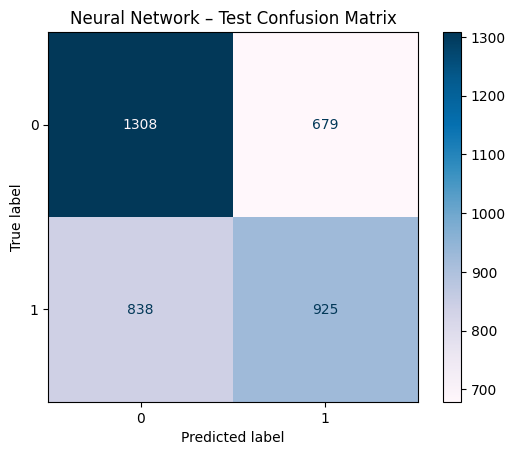

Classification report (test, Neural Network):
               precision    recall  f1-score   support

         0.0      0.610     0.658     0.633      1987
         1.0      0.577     0.525     0.549      1763

    accuracy                          0.595      3750
   macro avg      0.593     0.591     0.591      3750
weighted avg      0.594     0.595     0.594      3750



In [26]:
test_preds = (test_probs >= 0.5).astype(int)
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

acc = accuracy_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
print("Accuracy:", acc)
print("Confusion matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("Neural Network – Test Confusion Matrix")
plt.show()
print("Classification report (test, Neural Network):\n", classification_report(test_labels, test_preds, digits=3))

In [27]:
def get_embeddings(model, data_loader, device):
    model.eval()
    all_emb = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            # pass through all layers except the final linear output layer
            h = model.net[:-1](xb)
            all_emb.append(h.cpu().numpy())
            all_labels.append(yb.numpy())
    return np.concatenate(all_emb, axis=0), np.concatenate(all_labels, axis=0)

X_train_emb, y_train_emb = get_embeddings(model, train_loader, device)
X_val_emb,   y_val_emb   = get_embeddings(model, val_loader, device)
X_test_emb,  y_test_emb  = get_embeddings(model, test_loader, device)

emb_train, emb_val, emb_test = X_train_emb, X_val_emb, X_test_emb
y_train,  y_val,  y_test     = y_train_emb, y_val_emb, y_test_emb

np.save("../data_processed/embeddings_train.npy", emb_train)
np.save("../data_processed/embeddings_val.npy",   emb_val)
np.save("../data_processed/embeddings_test.npy",  emb_test)
np.save("../data_processed/y_train.npy",          y_train)
np.save("../data_processed/y_val.npy",            y_val)
np.save("../data_processed/y_test.npy",           y_test)

print("\nFiles in ../data_processed after saving:")
print(os.listdir("../data_processed"))


Files in ../data_processed after saving:
['embeddings_test.npy', 'embeddings_val.npy', 'y_train.npy', 'embeddings_train.npy', 'y_test.npy', 'y_val.npy', 'admissions_features.csv']


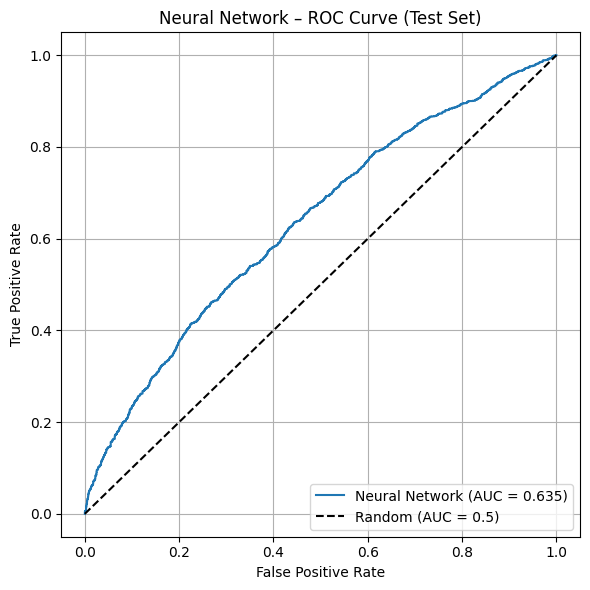

In [28]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Make sure probs are 1D
probs_1d = test_probs.ravel()

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels, probs_1d)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {test_auroc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network – ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Logistic regression on learned embeddings
This section reuses the neural network as a feature extractor, saves the hidden-layer embeddings, and fits a logistic regression model on those embeddings.

In [29]:
# 04_lr_on_embeddings.ipynb
"""
Logistic regression on neural network embeddings

This notebook loads the hidden layer embeddings from the feed forward neural network
(trained in 03_model_nn.ipynb) and trains a logistic regression classifier on top
of those embeddings. We then evaluate performance on validation and test sets and
compare to the baseline logistic regression on raw features.
"""

import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

import matplotlib.pyplot as plt

In [30]:
DATA_DIR = "../data_processed"

emb_train = np.load(os.path.join(DATA_DIR, "embeddings_train.npy"))
emb_val   = np.load(os.path.join(DATA_DIR, "embeddings_val.npy"))
emb_test  = np.load(os.path.join(DATA_DIR, "embeddings_test.npy"))

y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(DATA_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test.npy"))

print("Embedding shapes:")
print("  train:", emb_train.shape)
print("  val:  ", emb_val.shape)
print("  test: ", emb_test.shape)

print("\nPositive class rates:")
print("  train:", y_train.mean())
print("  val:  ", y_val.mean())
print("  test: ", y_test.mean())

Embedding shapes:
  train: (17500, 64)
  val:   (3750, 64)
  test:  (3750, 64)

Positive class rates:
  train: 0.47017142
  val:   0.47013333
  test:  0.47013333


In [31]:
def eval_lr(model, X, y, set_name="val"):
    """
    Evaluate a binary classifier with predict_proba on a dataset.
    Returns a metrics dict plus predictions and probabilities.
    """
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)

    metrics = {
        "set": set_name,
        "AUROC": roc_auc_score(y, probs),
        "AUPRC": average_precision_score(y, probs),
        "Accuracy": accuracy_score(y, preds),
    }
    return metrics, preds, probs

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
emb_train_scaled = scaler.fit_transform(emb_train)
emb_val_scaled = scaler.transform(emb_val)
emb_test_scaled = scaler.transform(emb_test)

lr_emb = LogisticRegression(
    penalty="l2",
    C=0.5,
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
)

lr_emb.fit(emb_train_scaled, y_train)

metrics_val, preds_val, probs_val = eval_lr(lr_emb, emb_val_scaled, y_val, "val")
metrics_test, preds_test, probs_test = eval_lr(lr_emb, emb_test_scaled, y_test, "test")

In [33]:
lr_emb.fit(emb_train, y_train)

print("Trained logistic regression on embeddings.")

Trained logistic regression on embeddings.


In [34]:
metrics_val, preds_val, probs_val = eval_lr(lr_emb, emb_val, y_val, "val")
metrics_test, preds_test, probs_test = eval_lr(lr_emb, emb_test, y_test, "test")

print("Validation metrics (LR on embeddings):")
print(metrics_val)

print("\nTest metrics (LR on embeddings):")
print(metrics_test)

Validation metrics (LR on embeddings):
{'set': 'val', 'AUROC': 0.6206586430630636, 'AUPRC': 0.5816421315104776, 'Accuracy': 0.5906666666666667}

Test metrics (LR on embeddings):
{'set': 'test', 'AUROC': 0.6264816600015815, 'AUPRC': 0.5991804936436808, 'Accuracy': 0.5952}


In [35]:
results_val = pd.DataFrame([{"model": "LR_on_embeddings", **metrics_val}]).set_index("model")
results_test = pd.DataFrame([{"model": "LR_on_embeddings", **metrics_test}]).set_index("model")

print("Validation:")
display(results_val)

print("\nTest:")
display(results_test)

Validation:


,set,AUROC,AUPRC,Accuracy
model,,,,
LR_on_embeddings,val,0.620659,0.581642,0.590667



Test:


,set,AUROC,AUPRC,Accuracy
model,,,,
LR_on_embeddings,test,0.626482,0.59918,0.5952


Confusion matrix (test, LR on embeddings):
[[1223  764]
 [ 754 1009]]


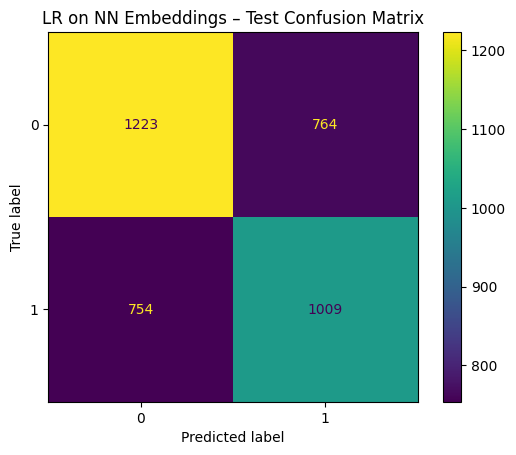


Classification report (test, LR on embeddings):
              precision    recall  f1-score   support

         0.0      0.619     0.616     0.617      1987
         1.0      0.569     0.572     0.571      1763

    accuracy                          0.595      3750
   macro avg      0.594     0.594     0.594      3750
weighted avg      0.595     0.595     0.595      3750



In [36]:
cm = confusion_matrix(y_test, preds_test)
print("Confusion matrix (test, LR on embeddings):")
print(cm)

disp = RocCurveDisplay

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(values_format="d")
plt.title("LR on NN Embeddings – Test Confusion Matrix")
plt.show()

print("\nClassification report (test, LR on embeddings):")
print(classification_report(y_test, preds_test, digits=3))

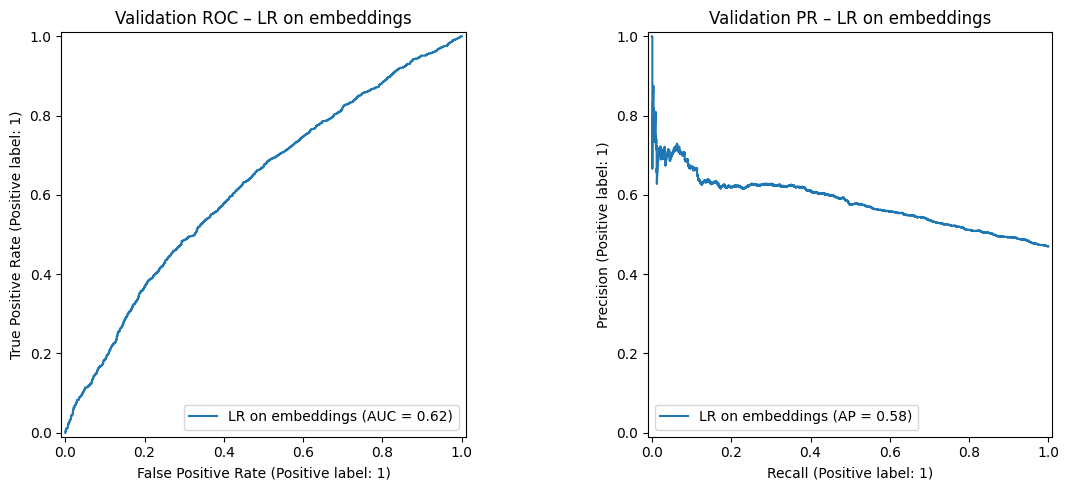

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_val, probs_val, ax=axes[0], name="LR on embeddings")
axes[0].set_title("Validation ROC – LR on embeddings")

PrecisionRecallDisplay.from_predictions(y_val, probs_val, ax=axes[1], name="LR on embeddings")
axes[1].set_title("Validation PR – LR on embeddings")

plt.tight_layout()
plt.show()